# Intelligent Loan Approval Prediction System ML Models
The system is designed to predict the likelihood of loan approval by analyzing historical data containing applicants’ financial and personal attributes. By employing advanced ML algorithms, the model can capture complex patterns and relationships between features, enabling more informed and objective predictions.

In this project, multiple machine learning models are explored and compared to identify the most effective approach for predicting loan approvals. The selected models include:

- Logistic Regression
- Random Forest
- XGBoost
- LightGBM
- Support Vector Machine (SVM)
- Neural Network

By training and evaluating these models on historical loan datasets, the system aims to provide a reliable, data-driven mechanism for loan approval prediction. This approach not only helps financial institutions minimize default risk but also ensures a fair and consistent evaluation process for applicants.

# Import Libraries

In [1]:
# records and calculations
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# core ML
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve

# gradient boosting model
import lightgbm as lgb
import xgboost as xgb

# neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

# optimization
import optuna
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Interpretability
import shap

# Fairness (optional)
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Persistence
import joblib
import pickle

#  Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# avoid minor warnings
import warnings
warnings.filterwarnings('ignore')

# read file path
from pathlib import Path

c:\Users\Tshihab07\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and Prepare Dataset for Modeling 

## Load Dataset

In [2]:
# reading file path
file = Path(r"../data/CleanedLoanData.csv")

# reading csv file
df = pd.read_csv(file)

In [3]:
df.head()

,Dependents,LoanAmount,CreditHistory,LoanStatus,TotalIncome,IncomeLoanRatio,LoanTermYears,Has_CoApplicantIncome,Gender_Male,Married_Yes,Education_Not Graduate,PropertyArea_Semiurban,PropertyArea_Urban,SelfEmployed_Yes
0,0,146.369492,1,1,5849.0,25.024704,30.0,0,True,False,False,False,True,False
1,1,128.000000,1,0,6091.0,21.014612,30.0,1,True,True,False,False,False,False
2,0,66.000000,1,1,3000.0,22.000000,30.0,0,True,True,False,False,True,True
3,0,120.000000,1,1,4941.0,24.286582,30.0,1,True,True,True,False,True,False
4,0,141.000000,1,1,6000.0,23.500000,30.0,0,True,False,False,False,True,False


## Feature-Target Separation

In [4]:
# input features
x = df.drop(columns=['LoanStatus'],  axis=1)

# target variable
y = df['LoanStatus']

## Train-Test Split and Cross-Validation Setup

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metric = 'roc_auc'

In [6]:
# Initialize storages
all_results = {}
models = {}
probability = {}
predictions = {}
performance = []

# Model Development

## Logistic Regression

### Model Training with Hyperparameter Optimization

In [7]:
# hyperparameter grid
lr_param_grid = {
    'C' : [0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

In [8]:
# Initialize base model
lr = LogisticRegression(random_state=42, max_iter=1000)

# GridSearch Optimization
lr_grid = GridSearchCV(
    lr,
    lr_param_grid,
    cv=cv,
    scoring=scoring_metric,
    n_jobs=-1
)

In [9]:
# train model and identify best estimator
lr_grid.fit(x_train, y_train)

models['Logistic Regression'] = lr_grid.best_estimator_

### Apply Model to Make Prediction and Get Probabilities

In [10]:
# make prediction on training and test set
train_pred = models['Logistic Regression'].predict(x_train)
test_pred = models["Logistic Regression"].predict(x_test)

In [11]:
# get predicted probabilities
train_proba = models['Logistic Regression'].predict_proba(x_train)[:, 1]
test_proba = models['Logistic Regression'].predict_proba(x_test)[:, 1]

In [12]:
# store results
predictions["Logistic Regression"] = test_pred
probability["Logistic Regression"] = test_proba

### Evaluation of The Model Performance

In [13]:
# Training Metrics
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score
train_accuracy = accuracy_score(y_train, train_pred)            # accuracy score

In [14]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score
test_accuracy = accuracy_score(y_test, test_pred)            # accuracy score

In [15]:
# performance table
print("=== Optimized Logistic Regression Performance ===")

metrics = [
    ("AUC-ROC", train_auc_roc, test_auc_roc),
    ('AUC-PR', train_auc_pr, test_auc_pr),
    ("Precision", train_precision, test_precision),
    ("Recall", train_recall, test_recall),
    ("F1-Score", train_f1, test_f1),
    ("Accuracy", train_acc, test_acc),
]

# Print header
print(f"{'Metric':<15}{'Training':<12}{'Test':<12}")
print("-" * 39)

# Print each row using a loop
for name, train_val, test_val in metrics:
    print(f"{name:<15}{train_val:<12.4f}{test_val:<12.4f}")

=== Optimized Logistic Regression Performance ===
Metric         Training    Test        
---------------------------------------
AUC-ROC        0.7768      0.8785      
AUC-PR         0.8582      0.9230      
Precision      0.8102      0.8780      
Recall         0.8537      0.8571      
F1-Score       0.8314      0.8675      
Accuracy       0.7623      0.8211      


In [16]:
# store test set performance
performance.append({
        'Model': 'Logistic Regression',
        'AUC-ROC': test_auc_roc,
        'AUC-PR': test_auc_pr,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1-Score': test_f1,
        'Accuracy': test_accuracy
    })

### ROC Curves

In [17]:
# roc curve for training and testing set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)

In [18]:
# calculate AUC for training and testing set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

In [19]:
# figure size
plt.figure(figsize=(8, 4))

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

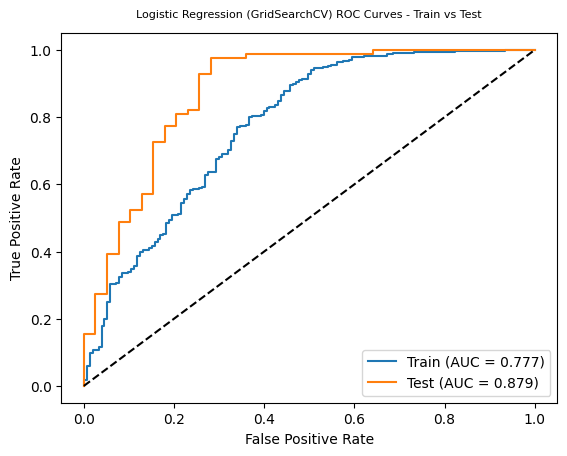

In [20]:
# ploting the curve
plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})')
plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')

# set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression (GridSearchCV) ROC Curves - Train vs Test',  y=1.02, fontsize=8)
plt.legend()
plt.show()

## Random Forest (GridSearchCV)

### Model Training with Hyperparameter Optimization

In [21]:
# hyperparameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

In [22]:
# Initialize base model
rf = RandomForestClassifier(random_state=42)

# GridSearch Optimization
rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=cv,
    scoring=scoring_metric,
    n_jobs=-1
)

In [23]:
# train model and identify best estimator
rf_grid.fit(x_train, y_train)

models['Random Forest (GridSearchCV)'] = rf_grid.best_estimator_

### Apply Model to Make Prediction and Get Probabilities

In [24]:
# make prediction on training and test set
train_pred = models['Random Forest (GridSearchCV)'].predict(x_train)
test_pred = models["Random Forest (GridSearchCV)"].predict(x_test)

In [25]:
# get predicted probabilities
train_proba = models['Random Forest (GridSearchCV)'].predict_proba(x_train)[:, 1]
test_proba = models['Random Forest (GridSearchCV)'].predict_proba(x_test)[:, 1]

In [26]:
# store results
predictions["Random Forest (GridSearchCV)"] = test_pred
probability["Random Forest (GridSearchCV)"] = test_proba

### Evaluation of The Model Performance

In [27]:
# performance on training set
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score
train_accuracy = accuracy_score(y_train, train_pred)            # accuracy score

In [28]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score
test_accuracy = accuracy_score(y_test, test_pred)            # accuracy score

In [29]:
# performance table
print("=== Optimized Random Forest Performance ===")

metrics = [
    ("AUC-ROC", train_auc_roc, test_auc_roc),
    ('AUC-PR', train_auc_pr, test_auc_pr),
    ("Precision", train_precision, test_precision),
    ("Recall", train_recall, test_recall),
    ("F1-Score", train_f1, test_f1),
    ("Accuracy", train_acc, test_acc),
]

# Print header
print(f"{'Metric':<15}{'Training':<12}{'Test':<12}")
print("-" * 39)

# Print each row using a loop
for name, train_val, test_val in metrics:
    print(f"{name:<15}{train_val:<12.4f}{test_val:<12.4f}")

=== Optimized Random Forest Performance ===
Metric         Training    Test        
---------------------------------------
AUC-ROC        0.9105      0.8745      
AUC-PR         0.9542      0.9268      
Precision      0.8433      0.8571      
Recall         0.9642      0.9286      
F1-Score       0.8997      0.8914      
Accuracy       0.8525      0.8455      


In [30]:
performance.append({
    "Model": "Random Forest (GridSearchCV)",
    'AUC-ROC': test_auc_roc,
    'AUC-PR': test_auc_pr,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-Score': test_f1,
    'Accuracy': test_accuracy
})

### ROC Curve

In [31]:
# roc-curve for training and test set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test,  test_proba)

In [32]:
# calculate AUC for trainign and test set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

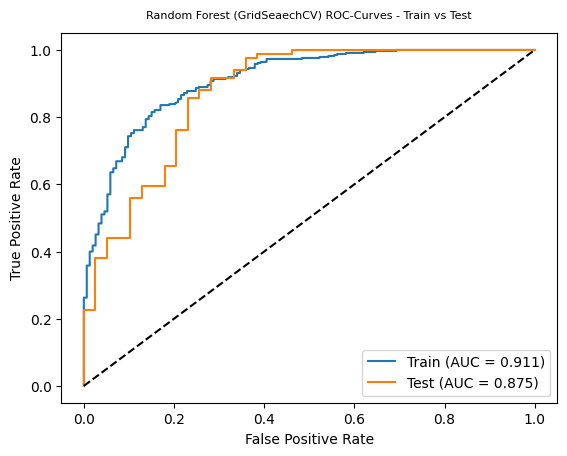

In [33]:
# plotting the curve
plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})')
plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')

# set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Random Forest (GridSeaechCV) ROC-Curves - Train vs Test", y=1.02, fontsize=8)
plt.legend()
plt.show()

## Support Vector Classification - SVC (BayesSearchCV)

### Model Trainign with Bayesian Hyperparameter Optimization

In [34]:
# Standardize features
svc_scaler = StandardScaler()
x_train_scale = svc_scaler.fit_transform(x_train)
x_test_scale = svc_scaler.fit_transform(x_test)

In [35]:
# hyperparameter tuning space
svc_param_space = {
    'C': Real(0.1, 100, prior='log-uniform'),
    'gamma': Real(0.001, 1, prior='log-uniform'),
    'kernel': Categorical(['rbf', 'linear']),
    'class_weight': Categorical(['balanced'])
}

In [36]:
# initialize base model
svc = SVC(probability=True, random_state=42)

# BayesSearch optimization
svc_bayes = BayesSearchCV(
    svc,
    svc_param_space,
    cv=cv,
    scoring=scoring_metric,
    n_iter = 20,
    n_jobs=-1,
    random_state=42
)

In [37]:
# train model and identify best estimator
svc_bayes.fit(x_train_scale, y_train)

models['SVC (BayesSearchCV)'] = svc_bayes.best_estimator_
models['SVC Scaler'] = svc_scaler

### Apply Model to Make Prediction and Get Probabilities

In [38]:
# make prediction on training and test set
train_pred = models['SVC (BayesSearchCV)'].predict(x_train_scale)
test_pred = models['SVC (BayesSearchCV)'].predict(x_test_scale)

In [39]:
# get predicted probabilities
train_proba = models['SVC (BayesSearchCV)'].predict_proba(x_train_scale)[:, 1]
test_proba = models['SVC (BayesSearchCV)'].predict_proba(x_test_scale)[:, 1]

In [40]:
# store results
predictions['SVC (BayesSearchCV)'] = test_pred
probability['SVC (BayesSearchCV)'] = test_proba

### Evaluation of The Model Performance

In [41]:
# Training Metrics
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score
train_accuracy = accuracy_score(y_train, train_pred)            # accuracy score

In [42]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score
test_accuracy = accuracy_score(y_test, test_pred)            # accuracy score

In [43]:
# performance table
print("=== Optimized Logistic Regression Performance ===")

metrics = [
    ("AUC-ROC", train_auc_roc, test_auc_roc),
    ('AUC-PR', train_auc_pr, test_auc_pr),
    ("Precision", train_precision, test_precision),
    ("Recall", train_recall, test_recall),
    ("F1-Score", train_f1, test_f1),
    ("Accuracy", train_acc, test_acc),
]

# Print header
print(f"{'Metric':<15}{'Training':<12}{'Test':<12}")
print("-" * 39)

# Print each row using a loop
for name, train_val, test_val in metrics:
    print(f"{name:<15}{train_val:<12.4f}{test_val:<12.4f}")

=== Optimized Logistic Regression Performance ===
Metric         Training    Test        
---------------------------------------
AUC-ROC        0.8422      0.8190      
AUC-PR         0.8914      0.8733      
Precision      0.8945      0.8475      
Recall         0.6328      0.5952      
F1-Score       0.7413      0.6993      
Accuracy       0.6967      0.6504      


In [44]:
# store test set performance
performance.append({
        'Model': 'Logistic Regression',
        'AUC-ROC': test_auc_roc,
        'AUC-PR': test_auc_pr,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1-Score': test_f1,
        'Accuracy': test_accuracy
    })

### ROC Curves

In [45]:
# roc curve for training and testing set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)

In [46]:
# calculate AUC for training and testing set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

In [47]:
# figure size
plt.figure(figsize=(8, 4))

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

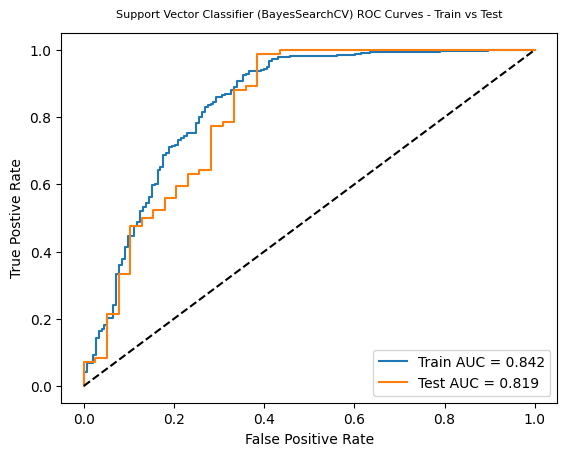

In [48]:
# plotting the curve
plt.plot(train_fpr, train_tpr, label=f'Train AUC = {train_auc:.3f}')
plt.plot(test_fpr, test_tpr, label=f'Test AUC = {test_auc:.3f}')
plt.plot([0, 1],  [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Postive Rate")
plt.title('Support Vector Classifier (BayesSearchCV) ROC Curves - Train vs Test',  y=1.02, fontsize=8)

plt.legend()
plt.show()

## LightGBM (Optuna Optimization)

In [49]:
# define the objective function for Optuna optimization
def lgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'n_jobs': -1,
        'class_weight': 'balanced'
    }

    model = lgb.LGBMClassifier(**params)
    scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring_metric)

    return scores.mean()

In [50]:
# create an Optuna study to maximize the objective
study_lgb = optuna.create_study(direction='maximize')

# run the optimization process for 30 trials
study_lgb.optimize(lgb_objective, n_trials=30, show_progress_bar=False)

[I 2025-09-17 23:30:50,915] A new study created in memory with name: no-name-9957a08a-9ee9-431a-9f87-230bbd447139


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 390, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-09-17 23:30:51,793] Trial 0 finished with value: 0.7423559621248594 and parameters: {'n_estimators': 135, 'max_depth': 8, 'learning_rate': 0.09931672654613324, 'subsample': 0.7205648627557965, 'colsample_bytree': 0.9874700590004264, 'reg_alpha': 6.706513540381275, 'reg_lambda': 4.139534625802032}. Best is trial 0 with value: 0.7423559621248594.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:30:52,242] Trial 1 finished with value: 0.7453522709035468 and parameters: {'n_estimators': 99, 'max_depth': 4, 'learning_rate': 0.014517600268381092, 'subsample': 0.8461028780928067, 'colsample_bytree': 0.865603889045887, 'reg_alpha': 4.609570544063651, 'reg_lambda': 0.849595331981986}. Best is trial 1 with value: 0.7453522709035468.


[LightGBM] [Info] Number of data points in the train set: 391, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:30:52,729] Trial 2 finished with value: 0.7448467340715776 and parameters: {'n_estimators': 161, 'max_depth': 4, 'learning_rate': 0.2181811195483556, 'subsample': 0.6774480797647995, 'colsample_bytree': 0.8760086762139883, 'reg_alpha': 2.975900927836519, 'reg_lambda': 9.332274675769762}. Best is trial 1 with value: 0.7453522709035468.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:30:53,124] Trial 3 finished with value: 0.7374321938693629 and parameters: {'n_estimators': 52, 'max_depth': 8, 'learning_rate': 0.25375430846805974, 'subsample': 0.6056904305877645, 'colsample_bytree': 0.84908885579732, 'reg_alpha': 1.3494885552830416, 'reg_lambda': 8.73190820172918}. Best is trial 1 with value: 0.7453522709035468.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 123
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 391, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-09-17 23:30:53,572] Trial 4 finished with value: 0.7543315679666185 and parameters: {'n_estimators': 74, 'max_depth': 5, 'learning_rate': 0.033108752987241245, 'subsample': 0.7621968960230937, 'colsample_bytree': 0.750369733605558, 'reg_alpha': 2.788663851072146, 'reg_lambda': 3.9394276519596683}. Best is trial 4 with value: 0.7543315679666185.


[LightGBM] [Info] Number of positive: 268, number of negative: 123
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 391, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-17 23:30:54,078] Trial 5 finished with value: 0.7560905151661049 and parameters: {'n_estimators': 112, 'max_depth': 6, 'learning_rate': 0.021402739732247194, 'subsample': 0.8730204987206346, 'colsample_bytree': 0.8172518643899536, 'reg_alpha': 1.4321178405648505, 'reg_lambda': 1.3711012537737355}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:30:54,639] Trial 6 finished with value: 0.7384224041084897 and parameters: {'n_estimators': 80, 'max_depth': 3, 'learning_rate': 0.021810098061566446, 'subsample': 0.8692534807496705, 'colsample_bytree': 0.798370191434092, 'reg_alpha': 4.205256344896052, 'reg_lambda': 5.411061963886571}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:30:54,932] Trial 7 finished with value: 0.729557053442465 and parameters: {'n_estimators': 53, 'max_depth': 8, 'learning_rate': 0.015135398485138648, 'subsample': 0.8454927907775005, 'colsample_bytree': 0.9477934147467983, 'reg_alpha': 7.637437566073806, 'reg_lambda': 3.782657124647262}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 390, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-09-17 23:30:55,787] Trial 8 finished with value: 0.7420157278125502 and parameters: {'n_estimators': 291, 'max_depth': 5, 'learning_rate': 0.05312169936042577, 'subsample': 0.9240132411841324, 'colsample_bytree': 0.7358661852444928, 'reg_alpha': 3.4528273310932125, 'reg_lambda': 6.632899101082329}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 390, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-09-17 23:30:56,862] Trial 9 finished with value: 0.7445289680629112 and parameters: {'n_estimators': 170, 'max_depth': 10, 'learning_rate': 0.06377853046123572, 'subsample': 0.9314226921041107, 'colsample_bytree': 0.9976766540804259, 'reg_alpha': 5.356423170669538, 'reg_lambda': 3.239501897295558}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:30:57,836] Trial 10 finished with value: 0.7436687530091478 and parameters: {'n_estimators': 225, 'max_depth': 6, 'learning_rate': 0.011077992779974904, 'subsample': 0.993612628616881, 'colsample_bytree': 0.6233702617060753, 'reg_alpha': 0.03290289366202792, 'reg_lambda': 0.4722116232443878}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 390, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-09-17 23:30:58,434] Trial 11 finished with value: 0.7521296742095972 and parameters: {'n_estimators': 116, 'max_depth': 6, 'learning_rate': 0.02934747624422191, 'subsample': 0.7586036896071424, 'colsample_bytree': 0.7195065280246418, 'reg_alpha': 1.9314807907183549, 'reg_lambda': 2.00383995739851}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:30:59,263] Trial 12 finished with value: 0.746528647087145 and parameters: {'n_estimators': 127, 'max_depth': 7, 'learning_rate': 0.03475540967639219, 'subsample': 0.8019062605719416, 'colsample_bytree': 0.7427980956113412, 'reg_alpha': 0.5680195895525681, 'reg_lambda': 2.147838814060093}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 390, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-09-17 23:30:59,823] Trial 13 finished with value: 0.7485427700208634 and parameters: {'n_estimators': 223, 'max_depth': 5, 'learning_rate': 0.04397689399668234, 'subsample': 0.7741751657051512, 'colsample_bytree': 0.6433498312798281, 'reg_alpha': 9.209397258443447, 'reg_lambda': 6.417285078013221}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-09-17 23:31:00,267] Trial 14 finished with value: 0.7529658160808859 and parameters: {'n_estimators': 84, 'max_depth': 5, 'learning_rate': 0.02267124870385326, 'subsample': 0.655265087026563, 'colsample_bytree': 0.7959597512410592, 'reg_alpha': 2.4093603147313534, 'reg_lambda': 2.1407430435256276}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 123
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 391, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-09-17 23:31:01,071] Trial 15 finished with value: 0.7382282137698605 and parameters: {'n_estimators': 203, 'max_depth': 7, 'learning_rate': 0.08749209906358577, 'subsample': 0.904771618936141, 'colsample_bytree': 0.70167076524858, 'reg_alpha': 1.33419530680062, 'reg_lambda': 4.970672572448485}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 390, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-09-17 23:31:01,701] Trial 16 finished with value: 0.7491750922805329 and parameters: {'n_estimators': 146, 'max_depth': 10, 'learning_rate': 0.023072015050160134, 'subsample': 0.7284157084327139, 'colsample_bytree': 0.9192578705889722, 'reg_alpha': 3.4031648317127985, 'reg_lambda': 0.12829673745655867}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 123
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 391, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-09-17 23:31:02,199] Trial 17 finished with value: 0.7400064195153266 and parameters: {'n_estimators': 98, 'max_depth': 3, 'learning_rate': 0.1291071463289868, 'subsample': 0.8095177049309443, 'colsample_bytree': 0.7765121691036125, 'reg_alpha': 6.039722192316486, 'reg_lambda': 2.9812665641975817}. Best is trial 5 with value: 0.7560905151661049.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 390, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-09-17 23:31:02,565] Trial 18 finished with value: 0.7562606323222597 and parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.037116769658274644, 'subsample': 0.9887297669873236, 'colsample_bytree': 0.6726960810152062, 'reg_alpha': 1.0996900018516644, 'reg_lambda': 1.3360925126483478}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:31:03,016] Trial 19 finished with value: 0.749626063232226 and parameters: {'n_estimators': 110, 'max_depth': 4, 'learning_rate': 0.015767972976313206, 'subsample': 0.9950787074110006, 'colsample_bytree': 0.6543960978178319, 'reg_alpha': 0.9290456492578916, 'reg_lambda': 1.2028170348607647}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:31:03,518] Trial 20 finished with value: 0.7488252286952335 and parameters: {'n_estimators': 194, 'max_depth': 6, 'learning_rate': 0.06291771909778265, 'subsample': 0.9554960683899177, 'colsample_bytree': 0.6804008075674417, 'reg_alpha': 9.744588155058626, 'reg_lambda': 1.5672711457388178}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 123
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 391, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-09-17 23:31:04,094] Trial 21 finished with value: 0.7524265767934522 and parameters: {'n_estimators': 72, 'max_depth': 5, 'learning_rate': 0.0367628879964185, 'subsample': 0.8907106439918657, 'colsample_bytree': 0.7634902929461883, 'reg_alpha': 2.19147691777716, 'reg_lambda': 2.8375653396592435}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:31:04,498] Trial 22 finished with value: 0.7544358850906757 and parameters: {'n_estimators': 67, 'max_depth': 4, 'learning_rate': 0.028024909009917442, 'subsample': 0.8271022880865239, 'colsample_bytree': 0.8315812028491162, 'reg_alpha': 2.6278669738064435, 'reg_lambda': 4.997172173585643}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2025-09-17 23:31:04,807] Trial 23 finished with value: 0.7340844166265447 and parameters: {'n_estimators': 51, 'max_depth': 3, 'learning_rate': 0.025401791291162292, 'subsample': 0.953675627718586, 'colsample_bytree': 0.8240378476751002, 'reg_alpha': 0.18466671762354736, 'reg_lambda': 7.2421060928838425}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 123
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 391, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-09-17 23:31:05,375] Trial 24 finished with value: 0.7517220349863586 and parameters: {'n_estimators': 95, 'max_depth': 4, 'learning_rate': 0.01763523800231995, 'subsample': 0.8276116303700227, 'colsample_bytree': 0.8993268565749861, 'reg_alpha': 1.6120125216216195, 'reg_lambda': 8.282832133230539}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 123
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 391, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-09-17 23:31:05,924] Trial 25 finished with value: 0.7505296100144438 and parameters: {'n_estimators': 147, 'max_depth': 4, 'learning_rate': 0.041495999817995656, 'subsample': 0.8764228179501458, 'colsample_bytree': 0.8370881949177791, 'reg_alpha': 3.7237455771848555, 'reg_lambda': 5.243397108363432}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:31:06,377] Trial 26 finished with value: 0.7479040282458675 and parameters: {'n_estimators': 69, 'max_depth': 9, 'learning_rate': 0.010843378830365107, 'subsample': 0.9684182067103307, 'colsample_bytree': 0.6045982390160649, 'reg_alpha': 2.1144459918331697, 'reg_lambda': 9.948978443632768}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-17 23:31:06,942] Trial 27 finished with value: 0.7376103354196758 and parameters: {'n_estimators': 117, 'max_depth': 3, 'learning_rate': 0.04831901297232946, 'subsample': 0.858326206000843, 'colsample_bytree': 0.8300419985474876, 'reg_alpha': 0.8210544133024251, 'reg_lambda': 0.09516703102458957}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 390, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-09-17 23:31:07,428] Trial 28 finished with value: 0.75492697801316 and parameters: {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.02825260703802337, 'subsample': 0.9205676795421178, 'colsample_bytree': 0.6852326653085234, 'reg_alpha': 2.8848155850769133, 'reg_lambda': 1.3620771942873386}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 390, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-09-17 23:31:07,982] Trial 29 finished with value: 0.7392232386454822 and parameters: {'n_estimators': 131, 'max_depth': 7, 'learning_rate': 0.08123545328331983, 'subsample': 0.9291085115375757, 'colsample_bytree': 0.6791332033547934, 'reg_alpha': 5.273631203079177, 'reg_lambda': 1.2020476673057774}. Best is trial 18 with value: 0.7562606323222597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f